# Introduction to Variant Allele Frequency
In the field of cancer research, calling mutations (_a.k.a_ variants) from the next-generation sequencing of the tumor sample is not an exact science. Each variant manifests itself in different ways within the data set and both biological and technical variance can make things challenging for the variant callers. Mutation caller tools provide additional metrics on each variant they call, to make it easier for researchers to investigate or filter variants for different purporses within different contexts.

The additional metrics on variants include but are not limited to: the depth of the sequencing around the variant, the number of reads supporting the reference or the mutated allele, the quality associated with the reads supporting a variant or how confident the tools was making a particular call. In this blog series, we are going to focus on the uses of one of these metrics, namely the **Variant Allele Frequency** (`VAF`).

VAF is a simple metric to describe what fraction of the reads spanning a particular variant region is supporting the variant — in other words, does not agree with the reference sequence. Files following the [Variant Call Format](https://en.wikipedia.org/wiki/Variant_Call_Format) standards report VAF under the `AF` field; but, it is also possible to calculate this value from the other annotation fields. As such, the following VCF annotations are all related to each other:

```
##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
##FORMAT=<ID=FA,Number=A,Type=Float,Description="Allele fraction of the alternate allele with regard to reference">
```

since:

\begin{equation*}
FA = \frac{AD_{alt}}{AD_{alt} + AD_{ref}} = \frac{AD_{alt}}{DP}.
\end{equation*}

As the name suggests, a variant's `VAF` ranges between `0` and `1`, where the former means there is no evidence in the read data supporting a variant and the latter indicates all reads from the sequencing data support the variants. In the tumor sequencing data from real patients, none of these extremes are observed due to the way variant calling algorithms work and the heterogenerity of a tumor sample (more on this later).

It is also worth noting that the stochastic nature of the sequencing technology causes the number of reads (supporting either the reference or the variant allele) to vary for each experiment. Because `VAF` is a ratio of two integers, the shallower the sequencing, the fewer reads fall onto the variant and the less stable the `VAF` becomes. 

Despite all these caveats, the distribution of `VAF`s for a sample has a lot to offer in terms of understanding some of clinically relevant properties of a tumor sample; *e.g.* purity or hetetogeneity. Before getting into the details, let's do some simulation to get ourselves familiar with `VAF` distributions. For this, we will be needing a few helper utilities:

In [1]:
import pandas as pd
import numpy as np

Our goal here is to simulate 1000 variants and their `VAF` measures and investigate this data set from a higher level. Since we are not that interested in the location or the nucleotide change, we will drop these information and only fill in our table with relevant statistics: depth, number of reads supporting the reference and the variant allele, and the VAF:

In [2]:
number_of_variants = 1000
average_depth = 100  # 100X

index = range(0, number_of_variants)
columns = ['depth', 'ref', 'alt', 'vaf']
variants = pd.DataFrame(index=index, columns=columns)

We are going to estimate the coverage with a `lognormal` and the VAF with a `beta` distribution (since it is a ratio). To make things even easier, let's assume that all of our variants are heterozygous and our sample to have `100%` purity. With that, we expect the `VAF`s to be centered around `50%` (or `0.5`) since a heterozygous mutation means that only one out of the two alleles is altered:

In [3]:
from numpy.random import RandomState
rs = RandomState(42)  # For reproducibility

lognormal_depths = rs.lognormal(mean=np.log(average_depth),
                                sigma=average_depth/100.0,  # arbitrary sigma
                                size=number_of_variants)
variants['depth'] = lognormal_depths.astype(int)

beta_vafs = rs.beta(a=average_depth, b=average_depth, size=number_of_variants)
variants['vaf'] = beta_vafs
variants['alt'] = (variants.depth * variants.vaf).astype(int)
variants['ref'] = variants.depth - variants.alt

# Let's save this for future use
variants.to_csv("./data/0-random_variants.csv")

variants.head()

,depth,ref,alt,vaf
0,164,81,83,0.511442
1,87,42,45,0.517862
2,191,95,96,0.506349
3,458,217,241,0.527326
4,79,37,42,0.537250


This is a good start: we now have 1000 variants with varying sequencing depth and `VAF` with some randomness to it. Let's take a look at how the overall distribution looks:

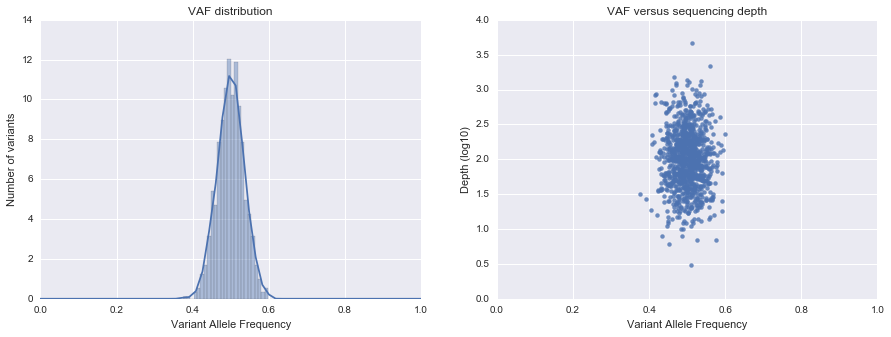

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# Get ready for our two panel descriptive plot
f, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 5))

sns.distplot(variants.vaf, ax=ax[0])
ax[0].set_title("VAF distribution")
ax[0].set_xlabel("Variant Allele Frequency")
ax[0].set_ylabel("Number of variants")
ax[0].set_xlim(0, 1.0)

sns.regplot(x=variants.vaf, y=np.log10(variants.depth), ax=ax[1], fit_reg=False)
ax[1].set_title("VAF versus sequencing depth")
ax[1].set_xlabel("Variant Allele Frequency")
ax[1].set_ylabel("Depth (log10)")
ax[1].set_xlim(0, 1.0)

plt.show()

This is a pretty neat VAF distribution centered around `50%` as we expected. This is as good as it can get for a sequencing experiment; but, of course, things are far from being ideal in real world and we often see much more complicated `VAF` distributions for tumor samples. Here is a summary figure showing data coming from a lung tumor:

![Lung tumor vafs](images/0-real_vaf.png)

And it does look different compared what we have from our simulated data set! The reason our tumor plot looks different than our simulated one has a lot to do with the biology of the tumor; but, this is going to be the topic of another post where we will go into the details of how different properties of tumor samples can affect these distributions. We will even show that  we can use a VCF file from a tumor sequencing experiment and recapitulate some of the properties of the tumor sample.